## Data Tokenization and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import datasets

In [2]:
articles = datasets.load_dataset('online_news_popularity_data')

Found cached dataset online_news_popularity_data (/home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/40871d81330db452a45539c72f8cf51048b7f8890bee79b1a6306eb6532df4b2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer
ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(ckpt)

In [4]:
def concatenate_fernandes_variables(examples):
    fernandes = [val for key, val in examples.items() if key not in ['title','content','shares','shares_class']]
    fernandes = np.array(fernandes).T.tolist()
    return {'fernandes': fernandes}

In [5]:
articles_concat = articles.map(concatenate_fernandes_variables, batched = True, batch_size = 64, num_proc = 16,
                              remove_columns = [x for x in articles.column_names['train'] if x not in ['title','content','shares','shares_class']] )

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/40871d81330db452a45539c72f8cf51048b7f8890bee79b1a6306eb6532df4b2/cache-de0dc50a5a27799a_*_of_00016.arrow


### Adding Tokenizer for image, twitter account, web url, and "(Opens in a new tab)"

In [6]:
articles_concat_sample = articles_concat['train'].select(range(10))

In [7]:
tokenizer.add_tokens(['web_link','opens_in_a_new_tab','twitter_acc','imgfile'], False)

4

In [8]:
tokenizer.get_added_vocab()

{'opens_in_a_new_tab': 30523,
 'web_link': 30522,
 'twitter_acc': 30524,
 'imgfile': 30525}

In [9]:
articles_concat_sample['title']

['Nancy Pelosi Ribs Reporter for Wearing Google Glass',
 "Newt Gingrich's Google Glass Tour Continues With Buzz Aldrin  ",
 'Nokia Slams the iPhone Camera in New Lumia Ad',
 'Obama Overturns Apple Ban and Other News You Need to Know',
 'Obama to Answer Housing Questions in Zillow Roundtable',
 "10 Things 'The O.C.' Taught Us About High School Romance",
 "Hulu Debuts Original Comedy Western Series 'Quick Draw'",
 "The Beginner's Guide to Rdio",
 '4 Ways to Recycle Your Old Gadgets',
 'Watch This Cock Float Through Space']

In [10]:
# Remove "(Opens in a new tab)" -> This may need a special token...
# Remove "http:// ..." or "https:// ... " (often followed by (Opens in a new tab))
# Remove "Image : ...(Opens in a new tab)" and "Image : ...(Opens in a new tab)/Tumblr"
text_sample = (articles_concat_sample['content'][8])

In [11]:
import re


text_sample_re = re.sub('@.+(?=[\(\s])','twitter_acc ', text_sample)
text_sample_re = re.sub('Image:.+(?=\(Opens in a new tab\))','imgfile ', text_sample_re)
text_sample_re = re.sub('.+\.com.*(?=\(Opens in a new tab\))', 'web_link ', text_sample_re)
text_sample_re = re.sub('\(Opens in a new tab\)',' opens_in_a_new_tab', text_sample_re)
text_sample_re = re.sub('http(s)?.+\s',' web_link ', text_sample_re)

In [12]:
{key: val in tokenizer.encode(text_sample_re) for key, val in tokenizer.get_added_vocab().items()}

Token indices sequence length is longer than the specified maximum sequence length for this model (1298 > 512). Running this sequence through the model will result in indexing errors


{'opens_in_a_new_tab': True,
 'web_link': False,
 'twitter_acc': False,
 'imgfile': True}

In [14]:
def clean_content_text(examples):
    content = examples['content']
    def clean_text(text_sample):
        text_sample_re = re.sub('@.+(?=[\(\s])','twitter_acc ', text_sample)
        text_sample_re = re.sub('Image:.+(?=\(Opens in a new tab\))','imgfile ', text_sample_re)
        text_sample_re = re.sub('.+\.com.*(?=\(Opens in a new tab\))', 'web_link ', text_sample_re)
        text_sample_re = re.sub('\(Opens in a new tab\)',' opens_in_a_new_tab', text_sample_re)
        text_sample_re = re.sub('http(s)?.+\s',' web_link ', text_sample_re)
        return text_sample_re
    return {'content': list(map(clean_text, content))}

In [15]:
articles_concat = articles_concat.map(clean_content_text, batched = True)

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/40871d81330db452a45539c72f8cf51048b7f8890bee79b1a6306eb6532df4b2/cache-8567f7135922307b.arrow


In [16]:
max_length = 0
for text in articles_concat['train']['content']:
    if len(text.split(' '))*2 > max_length:
        N = len(tokenizer.encode(text, add_special_tokens = False))
        if N > max_length:
            max_length = N

In [17]:
max_length

10019

In [18]:
title_max_length = 0
for text in articles_concat['train']['title']:
    if len(text.split(' '))*2 > title_max_length:
        N = len(tokenizer.encode(text, add_special_tokens = False))
        if N > title_max_length:
            title_max_length = N

In [19]:
title_max_length

32

### Tokenize

In [20]:
def tokenize(single_text):
    title_tokenized = tokenizer(single_text['title'][0], add_special_tokens = False)
    title_token_size = len(title_tokenized['input_ids'])
    content = single_text['content'][0]
    if isinstance(content, str):
        content_length = len(tokenizer.encode(content, add_special_tokens = False))
    else:
        raise ValueError("single_text['content'] must be a string")
    
    content_max_length = (509-title_token_size)
    if content_length > content_max_length*1.05:
        m = content_length//content_max_length
        m += 1
        stride = (content_max_length * m - content_length)//(m-1) + 1
        flag = True
        while flag:
            try:
                content_tokenized = tokenizer('', text_pair = content, 
                                              truncation = True,
                                              padding = 'max_length',
                                              max_length = content_max_length+3,
                                              stride = stride,
                                              return_overflowing_tokens = True
                                             )
                content_tokenized['overflow_to_sample_mapping'] = [m+1 for _ in range(m+1)]
                flag = False
            except:
                m += 1
                stride = (content_max_length * m - content_length)//(m-1) + 1
    else:
        m = 0
        content_tokenized = tokenizer([''], text_pair = [content], 
                                      padding = 'max_length',
                                      truncation = True,
                                      max_length = content_max_length+3,
                                      return_overflowing_tokens = False
                                     )
        content_tokenized['overflow_to_sample_mapping'] = [1]

    for key,val in content_tokenized.items():
        if key in title_tokenized.keys():
            for i in range(len(val)):
                content_tokenized[key][i] = content_tokenized[key][i][:1] + title_tokenized[key] + content_tokenized[key][i][1:]
    return content_tokenized

In [21]:
articles_tokenized = articles_concat.map(tokenize, batched = True, batch_size = 1, num_proc = 16,
                   remove_columns = articles_concat_sample.column_names)

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/40871d81330db452a45539c72f8cf51048b7f8890bee79b1a6306eb6532df4b2/cache-f6fd3c52a4ac9862_*_of_00016.arrow


In [27]:
[[1]]*2

[[1], [1]]

In [38]:
from random import choices
choices(range(3),  k=6)

[0, 2, 0, 0, 0, 2]

In [37]:
[[1],[2]]*2

[[1], [2], [1], [2]]

In [39]:
# duplicating so that each articles has 22 cases

from random import choices

def duplicate(single_text):
    num_rows = len(single_text['overflow_to_sample_mapping'])
    if num_rows == 1:
        result = {key: val*22 for key, val in single_text.items() if key not in ['overflow_to_sample_mapping']}
    else:
        if num_rows < 22:
            while len(single_text['overflow_to_sample_mapping'])*2 < 22:
                single_text =  {key: val*2 for key, val in single_text.items()}
            random_rows_num = 22 - len(single_text['overflow_to_sample_mapping'])
            random_indices = choices(range(len(single_text['overflow_to_sample_mapping'])), random_rows_num)
            result =  {key: val + [val[i] for i in random_indices] for key, val in single_text.items() \
                            if key not in ['overflow_to_sample_mapping']}
        else:
            result = {key: val for key, val in single_text.items() \
                            if key not in ['overflow_to_sample_mapping']}
    return result
    
        

In [48]:
# after duplicate, 1 epoch in training technically means 7.5 epochs.
# Therefore, to have 100 epochs, you need... 13 epochs
100//(22/np.mean(articles_tokenized['train']['overflow_to_sample_mapping']))

13.0

In [49]:
articles_tokenized = articles_tokenized.map(duplicate, batched = True, batch_size = 1, remove_columns = ['overflow_to_sample_mapping'],
                          num_proc = 16)

Loading cached processed dataset at /home/leeparkuky/.cache/huggingface/datasets/online_news_popularity_data/online_news_popularity_data/1.0.0/40871d81330db452a45539c72f8cf51048b7f8890bee79b1a6306eb6532df4b2/cache-5d46025f24595a89_*_of_00016.arrow


In [23]:
# # Checking every length is 512
# lengths = []
# for ids in articles_tokenized['train']['input_ids']:
#     if len(ids) not in lengths:
#         lengths.append(len(ids))

# lengths

[512]

In [50]:
articles_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1631894
    })
})

In [51]:
articles_tokenized.set_format('pt')

In [52]:
articles_tokenized = articles_tokenized['train'].train_test_split(.01/7.5)

# Domain Adaptation Training for BERT without Fernandes Embedding (TAPT)

In [53]:
articles_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1629718
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2176
    })
})

In [54]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [55]:
from transformers import BertForMaskedLM

model_ckpt = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_ckpt)
delattr(model, 'cls')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")
    
print_gpu_utilization()

GPU memory occupied: 1007 MB.


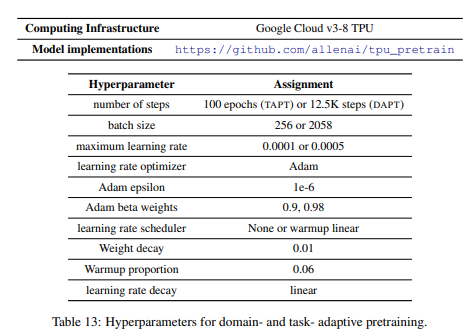

In [57]:
# hyperparameters
from transformers import AdamW


epochs = 100
total_batch_size = 256
per_device_train_batch_size = 16
betas = (.9, .98)
lr = 1e-4
eps = 1e-6
weight_decay = 0.06
# optim = AdamW(params = model.parameters(), lr = lr, betas = betas, eps = eps, weight_decay = wd, )

In [58]:
# Eval metric (accuracy)
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [59]:
model.config.vocab_size

30522

In [60]:
model.config.vocab_size +=  4 # we added 4 tokens

In [61]:
model.config.vocab_size

30526

In [62]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir="TAPT-BERT-MLM",
    overwrite_output_dir = True,
    evaluation_strategy="epoch",
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = 4,
    fp16 = True,
    num_train_epochs= epochs,
    push_to_hub=False,
    gradient_accumulation_steps = total_batch_size//per_device_train_batch_size, #total batch size
    gradient_checkpointing=True,
    optim = 'adamw_torch',
    adam_beta1  = betas[0],
    adam_beta2  = betas[1],
    learning_rate  = 1e-4,
    adam_epsilon  = 1e-6,
    weight_decay = 0.06,
    save_total_limit = 10
)


trainer = Trainer(
    model=model.to(torch.device('cuda')),
    args=training_args,
    train_dataset=articles_tokenized["train"],
    eval_dataset=articles_tokenized["test"],
    data_collator=data_collator,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer
)

In [63]:
print_gpu_utilization()

GPU memory occupied: 1928 MB.


In [64]:
trainer.train(resume_from_checkpoint=False)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [32,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [32,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [32,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [32,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [32,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/A

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.train(resume_from_checkpoint=False)                                                  │
│   2                                                                                              │
│                                                                                                  │
│ /home/leeparkuky/.local/lib/python3.10/site-packages/transformers/trainer.py:1633 in train       │
│                                                                                                  │
│   1630 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1631 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1632 │   │   )                                                                                 │
│ ❱ 1633 │   │   return inner_training_loop(                                                       │
│   1634 │   │   │   args=args,                                                                    │
│   1635 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1636 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /home/leeparkuky/.local/lib/python3.10/site-packages/transformers/trainer.py:1902 in             │
│ _inner_training_loop                                                                             │
│                                                                                                  │
│   1899 │   │   │   │   │   with model.no_sync():                                                 │
│   1900 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1901 │   │   │   │   else:                                                                     │
│ ❱ 1902 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1903 │   │   │   │                                                                             │
│   1904 │   │   │   │   if (                                                                      │
│   1905 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /home/leeparkuky/.local/lib/python3.10/site-packages/transformers/trainer.py:2645 in             │
│ training_step                                                                                    │
│                                                                                                  │
│   2642 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2643 │   │                                                                                     │
│   2644 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2645 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2646 │   │                                                                                     │
│   2647 │   │   if self.args.n_gpu > 1:                                                           │
│   2648 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /home/leeparkuky/.local/lib/python3.10/site-packages/transformers/trainer.py:2677 in             │
│ compute_loss                                               

# Tesing if "MashableBertForMaskedLM" works

In [14]:
# from Transformer_Models import MashableBertForMaskedLM

# model_ckpt = 'bert-base-uncased'
# model = MashableBertForMaskedLM(model_ckpt)

In [15]:
# model(**{k:v for k,v in articles_tokenized['train'][:3].items()})

# Organizing Training Job for MaskedLM

In [16]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [17]:
from Transformer_Models import MashableBertForMaskedLM

model_ckpt = 'bert-base-uncased'
model = MashableBertForMaskedLM(model_ckpt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
print_gpu_utilization()

GPU memory occupied: 659 MB.


In [22]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir="pretraining-mashablebert",
    overwrite_output_dir = True,
    evaluation_strategy="epoch",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 4,
    fp16 = True,
    learning_rate=2e-5,
    num_train_epochs=40,
    weight_decay=0.01,
    push_to_hub=False,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim = 'adafactor',
    save_total_limit = 10
)


trainer = Trainer(
    model=model.to(torch.device('cuda')),
    args=training_args,
    train_dataset=articles_tokenized["train"],
    eval_dataset=articles_tokenized["test"],
    data_collator=data_collator,
)



In [23]:
print_gpu_utilization()

GPU memory occupied: 1695 MB.


In [26]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss
26,1.805300,1.760977
27,1.798700,1.755535
28,1.786900,1.739120
29,1.777900,1.735988
30,1.769800,1.737841
31,1.761900,1.748289
32,1.757800,1.724742
33,1.753000,1.726164
34,1.750800,1.726214
35,1.751700,1.714100


TrainOutput(global_step=49480, training_loss=0.6207000078649991, metrics={'train_runtime': 30370.2547, 'train_samples_per_second': 52.126, 'train_steps_per_second': 1.629, 'total_flos': 5.379350296572703e+17, 'train_loss': 0.6207000078649991, 'epoch': 40.0})

1237 steps per epoch

In [28]:
trainer.save_model('MashableBertForMaskedLM_Pretrained')

In [35]:
from Transformer_Models import MashableBertModel

bertmodel = MashableBertModel('bert-base-uncased')

In [40]:
pretrained_state_dict = trainer.model.state_dict()

state_dict = {}
state_dict_keys = ['.'.join(x.split('.')[1:]) for x in pretrained_state_dict.keys()]
state_dict_keys_maps = {'.'.join(x.split('.')[1:]):x for x in pretrained_state_dict.keys()}
for key, val in bertmodel.state_dict().items():
    if key in state_dict_keys:
        state_dict[key] = pretrained_state_dict[state_dict_keys_maps[key]]
    elif key in pretrained_state_dict.keys():
        state_dict[key] = pretraeind_state_dict[key]


In [42]:
bertmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [43]:
torch.save(bertmodel.state_dict(), 'Model Weights/MashableBertModel_Pretrained.pth')

### Apendix: Training and Validation Loss Per Epoch Table

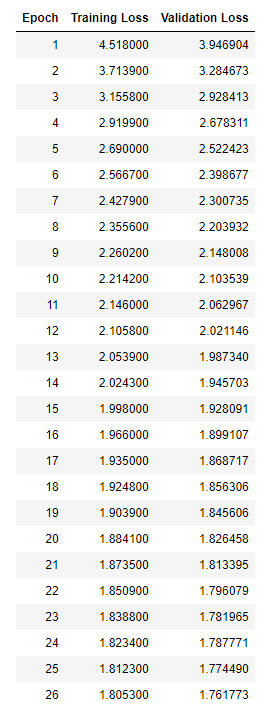

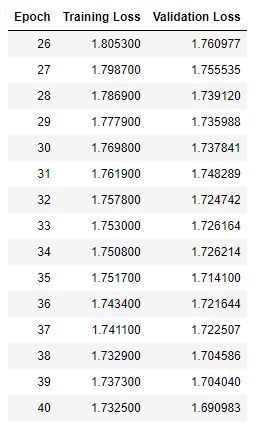